In [1]:
import numpy as np
import sys
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [3]:
sys.path.append("/home/joshuasobrin/spt3g/spt3g_software/build")

In [4]:
from spt3g import core, mapmaker

# Load summary statistics for relevant months #

This code considers only a single frequency band!  Simply change the input bands in the code-block below as-needed.

In [5]:
data_201903 = core.G3File("/spt/user/weiquan/map_quality/hi_res_maps/monthly/201903/coadded_maps_90GHz.g3.gz")
data_201904 = core.G3File("/spt/user/weiquan/map_quality/hi_res_maps/monthly/201904/coadded_maps_90GHz.g3.gz")
data_201905 = core.G3File("/spt/user/weiquan/map_quality/hi_res_maps/monthly/201905/coadded_maps_90GHz.g3.gz")
data_201906 = core.G3File("/spt/user/weiquan/map_quality/hi_res_maps/monthly/201906/coadded_maps_90GHz.g3.gz")
data_201907 = core.G3File("/spt/user/weiquan/map_quality/hi_res_maps/monthly/201907/coadded_maps_90GHz.g3.gz")
data_201908 = core.G3File("/spt/user/weiquan/map_quality/hi_res_maps/monthly/201908/coadded_maps_90GHz.g3.gz")

In [6]:
data_201903 = data_201903.next()
data_201904 = data_201904.next()
data_201905 = data_201905.next()
data_201906 = data_201906.next()
data_201907 = data_201907.next()
data_201908 = data_201908.next()

In [7]:
month_list = [data_201903, data_201904, data_201905, data_201906, data_201907, data_201908]

# Create Dictionary #

In [8]:
master_dict = {}

for month in month_list:
    for subfield in month["CoaddedObservationIDs"]:
        for obsid in subfield[1]:
            master_dict[str(obsid)] = {}
            master_dict[str(obsid)]["subfield"] = subfield[0]

In [9]:
obs_before_sundown = []

for key in master_dict:
    
    # Handle different months
    if int(key) < 70000000:
        obs_before_sundown.append(key)
        continue
    elif 70000000 <= int(key) <= 70825959:
        month = data_201903
    elif 70861558 <= int(key) <= 73437150:
        month = data_201904
    elif 73445934 <= int(key) <= 76113857:
        month = data_201905
    elif 76125456 <= int(key) <= 78601914:
        month = data_201906
    elif 78816157 <= int(key) <= 81347533:
        month = data_201907
    elif 81404835 <= int(key) <= 84066968:
        month = data_201908
    else:
        print("Found an out of range obsid:", int(key))
        continue
    
    master_dict[key]["noise"] = (month["NoiseLevelsFromIndividualTMaps"][master_dict[key]["subfield"]][key])/(core.G3Units.uK*core.G3Units.arcmin)
    
    master_dict[key]["bolos"] = month["FlaggingStatisticsAverageNumbersOfAllBolosTotalNotFlagged"][master_dict[key]["subfield"]][key]
    
    master_dict[key]["cross_spectrum"] = month["AveragesOfRatiosOfSPTxPlancktoPlckxPlckTTspectra"][master_dict[key]["subfield"]][key]
    
    master_dict[key]["coverage"] = month["FluctuationMetricsIndividualSignalMapsNumbersOfPixelsWithGoodTTWeights"][master_dict[key]["subfield"]][key]
    
    master_dict[key]["linearity"] = month["MedianCalibratorResponseAllBolosFractionalChangesTopToBottom"][master_dict[key]["subfield"]][key]*100
    
    master_dict[key]["RA_delta_1"] = month["DeltaRasOf1stBrightestSourceFromEachSubfield"][master_dict[key]["subfield"]][key]/core.G3Units.arcsec
    master_dict[key]["RA_delta_2"] = month["DeltaRasOf2ndBrightestSourceFromEachSubfield"][master_dict[key]["subfield"]][key]/core.G3Units.arcsec
    master_dict[key]["RA_delta_3"] = month["DeltaRasOf3rdBrightestSourceFromEachSubfield"][master_dict[key]["subfield"]][key]/core.G3Units.arcsec
    master_dict[key]["dec_delta_1"] = month["DeltaDecsOf1stBrightestSourceFromEachSubfield"][master_dict[key]["subfield"]][key]/core.G3Units.arcsec
    master_dict[key]["dec_delta_2"] = month["DeltaDecsOf2ndBrightestSourceFromEachSubfield"][master_dict[key]["subfield"]][key]/core.G3Units.arcsec
    master_dict[key]["dec_delta_3"] = month["DeltaDecsOf3rdBrightestSourceFromEachSubfield"][master_dict[key]["subfield"]][key]/core.G3Units.arcsec

print(len(obs_before_sundown), "observations before sundown:", sorted(obs_before_sundown))

#Remove pre-sundown observations from dictionary
for obs in obs_before_sundown:
    master_dict.pop(obs)

#Create a copy of master_dict from which we'll remove flagged observations
surviving_dict = master_dict.copy()

#Count baseline number of observations
print("")
print(len(surviving_dict.keys()), "observations to consider.")

7 observations before sundown: ['69901979', '69913074', '69925559', '69936683', '69974634', '69985528', '69996325']

1008 observations to consider.


# Investigate Noise #

$\sqrt C_\ell$s are calculated, and then averaged between 3000 < $\ell$ < 5000 (where noise dominates over signal). Units are in uK*arcmin.

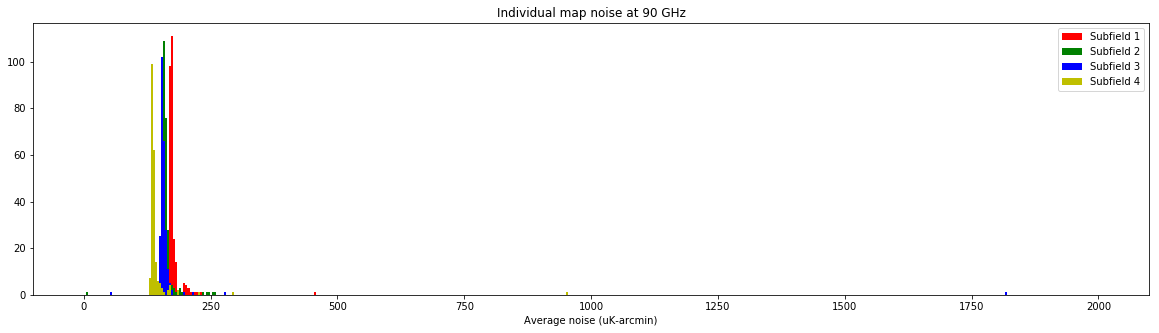

In [10]:
hist_noise_1_master = []
hist_noise_2_master = []
hist_noise_3_master = []
hist_noise_4_master = []

for key in master_dict:
    if master_dict[key]["subfield"] == "ra0hdec-44.75":
        hist_noise_1_master.append(master_dict[key]["noise"])
    elif master_dict[key]["subfield"] == "ra0hdec-52.25":
        hist_noise_2_master.append(master_dict[key]["noise"])
    elif master_dict[key]["subfield"] == "ra0hdec-59.75":
        hist_noise_3_master.append(master_dict[key]["noise"])
    elif master_dict[key]["subfield"] == "ra0hdec-67.25":
        hist_noise_4_master.append(master_dict[key]["noise"])
    else:
        print("Something weird happened.")

hist_noise_bin_edges = np.linspace(0, 2000, 500)

plt.figure(figsize=(20,5))
plt.hist(hist_noise_1_master, bins=hist_noise_bin_edges, color="r", label="Subfield 1")
plt.hist(hist_noise_2_master, bins=hist_noise_bin_edges, color="g", label="Subfield 2")
plt.hist(hist_noise_3_master, bins=hist_noise_bin_edges, color="b", label="Subfield 3")
plt.hist(hist_noise_4_master, bins=hist_noise_bin_edges, color="y", label="Subfield 4")
plt.title("Individual map noise at 90 GHz")
plt.xlabel("Average noise (uK-arcmin)")
plt.legend(loc="upper right")
plt.show()

In [11]:
obs_bad_noise_master = []

for key in master_dict:
    if not 100 < master_dict[key]["noise"] < 300:
        obs_bad_noise_master.append(key)
    else:
        continue

for obs in obs_bad_noise_master:
    surviving_dict.pop(obs)

print(len(obs_bad_noise_master), "observations have anomalous noise:", sorted(obs_bad_noise_master))
print("")
print(len(surviving_dict.keys()), "observations remain.")

5 observations have anomalous noise: ['71718785', '71853745', '73102483', '75850013', '78816157']

1003 observations remain.


# Investigate Bolometer Cuts #

Average number of unflagged bolometers per scan throughout the observation

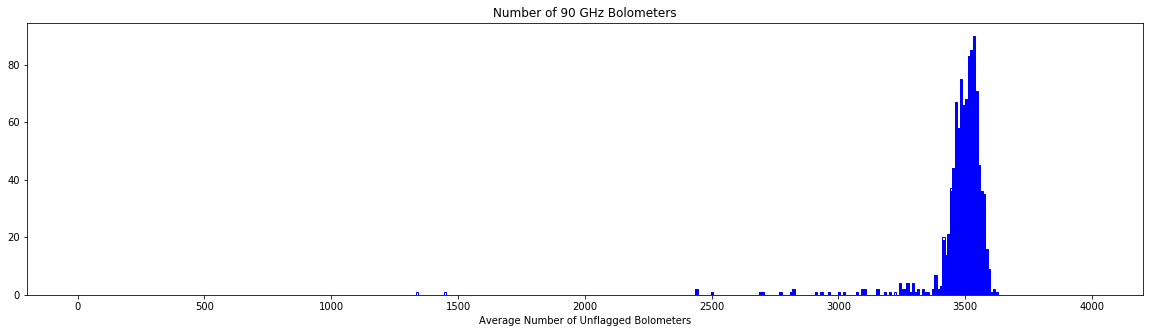

In [12]:
hist_bolos_master = []
hist_bolos_surviving = []

for key in master_dict:
    hist_bolos_master.append(master_dict[key]["bolos"])

for key in surviving_dict:
    hist_bolos_surviving.append(surviving_dict[key]["bolos"])

hist_bolos_bin_edges = np.linspace(0, 4000, 400)

plt.figure(figsize=(20,5))
plt.hist(hist_bolos_master, bins=hist_bolos_bin_edges, histtype="step", color="b")
plt.hist(hist_bolos_surviving, bins=hist_bolos_bin_edges, color="b")
plt.title("Number of 90 GHz Bolometers")
plt.xlabel("Average Number of Unflagged Bolometers")
plt.show()

In [13]:
obs_bad_bolos_master = []
obs_bad_bolos_surviving = []

for key in master_dict:
    if master_dict[key]["bolos"] < 2500:
        obs_bad_bolos_master.append(key)
    else:
        continue

for key in surviving_dict:
    if surviving_dict[key]["bolos"] < 2500:
        obs_bad_bolos_surviving.append(key)
    else:
        continue

print(len(obs_bad_bolos_master), "observations have too many flagged bolos:", sorted(obs_bad_bolos_master))
print("")
print(len(obs_bad_bolos_surviving), "new observations have too many flagged bolos:", sorted(obs_bad_bolos_surviving))
print("")

for obs in obs_bad_bolos_surviving:
    surviving_dict.pop(obs)

print(len(surviving_dict.keys()), "observations remain.")

4 observations have too many flagged bolos: ['71718785', '75850013', '78997909', '79006720']

2 new observations have too many flagged bolos: ['78997909', '79006720']

1001 observations remain.


# Investigate Coverage #

For every subfield, a weight-value threshold (per-pixel-on-the-sky) is set.  This statistic counts how many pixels in the map have a weight-value above this threshold. 

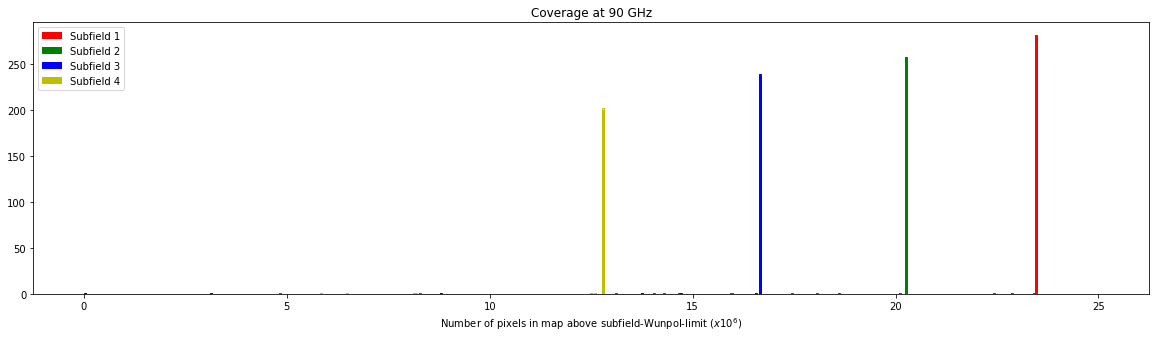

In [14]:
hist_coverage_1_master = []
hist_coverage_2_master = []
hist_coverage_3_master = []
hist_coverage_4_master = []

hist_coverage_1_surviving = []
hist_coverage_2_surviving = []
hist_coverage_3_surviving = []
hist_coverage_4_surviving = []

for key in master_dict:
    if master_dict[key]["subfield"] == "ra0hdec-44.75":
        hist_coverage_1_master.append(master_dict[key]["coverage"]/10**6)
    elif master_dict[key]["subfield"] == "ra0hdec-52.25":
        hist_coverage_2_master.append(master_dict[key]["coverage"]/10**6)
    elif master_dict[key]["subfield"] == "ra0hdec-59.75":
        hist_coverage_3_master.append(master_dict[key]["coverage"]/10**6)
    elif master_dict[key]["subfield"] == "ra0hdec-67.25":
        hist_coverage_4_master.append(master_dict[key]["coverage"]/10**6)
    else:
        print("Something weird happened")

for key in surviving_dict:
    if master_dict[key]["subfield"] == "ra0hdec-44.75":
        hist_coverage_1_surviving.append(master_dict[key]["coverage"]/10**6)
    elif master_dict[key]["subfield"] == "ra0hdec-52.25":
        hist_coverage_2_surviving.append(master_dict[key]["coverage"]/10**6)
    elif master_dict[key]["subfield"] == "ra0hdec-59.75":
        hist_coverage_3_surviving.append(master_dict[key]["coverage"]/10**6)
    elif master_dict[key]["subfield"] == "ra0hdec-67.25":
        hist_coverage_4_surviving.append(master_dict[key]["coverage"]/10**6)
    else:
        print("Something weird happened")

hist_coverage_bin_edges = np.linspace(0, 25, 500)

plt.figure(figsize=(20,5))
plt.hist(hist_coverage_1_master, bins=hist_coverage_bin_edges, histtype="step", color="r")
plt.hist(hist_coverage_2_master, bins=hist_coverage_bin_edges, histtype="step", color="g")
plt.hist(hist_coverage_3_master, bins=hist_coverage_bin_edges, histtype="step", color="b")
plt.hist(hist_coverage_4_master, bins=hist_coverage_bin_edges, histtype="step", color="y")
plt.hist(hist_coverage_1_surviving, bins=hist_coverage_bin_edges, color="r", label="Subfield 1")
plt.hist(hist_coverage_2_surviving, bins=hist_coverage_bin_edges, color="g", label="Subfield 2")
plt.hist(hist_coverage_3_surviving, bins=hist_coverage_bin_edges, color="b", label="Subfield 3")
plt.hist(hist_coverage_4_surviving, bins=hist_coverage_bin_edges, color="y", label="Subfield 4")
plt.title("Coverage at 90 GHz")
plt.xlabel("Number of pixels in map above subfield-Wunpol-limit ($x10^6$)")
plt.legend(loc="upper left")
plt.show()

In [15]:
obs_bad_coverage_master = []
obs_bad_coverage_surviving = []

for key in master_dict:
    if master_dict[key]["subfield"] == "ra0hdec-44.75":
        if not 23.3 < master_dict[key]["coverage"]/10**6 < 23.5:
            obs_bad_coverage_master.append(key)
        else:
            continue
    elif master_dict[key]["subfield"] == "ra0hdec-52.25":
        if not 20.1 < master_dict[key]["coverage"]/10**6 < 20.3:
            obs_bad_coverage_master.append(key)
        else:
            continue
    elif master_dict[key]["subfield"] == "ra0hdec-59.75":
        if not 16.5 < master_dict[key]["coverage"]/10**6 < 16.7:
            obs_bad_coverage_master.append(key)
        else:
            continue
    elif master_dict[key]["subfield"] == "ra0hdec-67.25":
        if not 12.65 < master_dict[key]["coverage"]/10**6 < 12.85:
            obs_bad_coverage_master.append(key)
        else:
            continue
    else:
        print("Something weird happened")

for key in surviving_dict:
    if surviving_dict[key]["subfield"] == "ra0hdec-44.75":
        if not 23.3 < master_dict[key]["coverage"]/10**6 < 23.5:
            obs_bad_coverage_surviving.append(key)
        else:
            continue
    elif surviving_dict[key]["subfield"] == "ra0hdec-52.25":
        if not 20.1 < master_dict[key]["coverage"]/10**6 < 20.3:
            obs_bad_coverage_surviving.append(key)
        else:
            continue
    elif surviving_dict[key]["subfield"] == "ra0hdec-59.75":
        if not 16.5 < master_dict[key]["coverage"]/10**6 < 16.7:
            obs_bad_coverage_surviving.append(key)
        else:
            continue
    elif surviving_dict[key]["subfield"] == "ra0hdec-67.25":
        if not 12.65 < master_dict[key]["coverage"]/10**6 < 12.85:
            obs_bad_coverage_surviving.append(key)
        else:
            continue
    else:
        print("Something weird happened")

print(len(obs_bad_coverage_master), "observations have missing coverage:", sorted(obs_bad_coverage_master))
print("")
print(len(obs_bad_coverage_surviving), "new observations have missing coverage:", sorted(obs_bad_coverage_surviving))

for obs in obs_bad_coverage_surviving:
    surviving_dict.pop(obs)

print("")
print(len(surviving_dict.keys()), "observations remain.")

26 observations have missing coverage: ['70019142', '70095756', '70344984', '70366963', '70412736', '70482836', '70553740', '70613613', '71131345', '71825113', '71853745', '71899844', '72243773', '73102483', '73275784', '73582657', '75850013', '77826016', '77834811', '78312893', '78601914', '78816157', '82353107', '82364506', '82795786', '83298960']

22 new observations have missing coverage: ['70019142', '70095756', '70344984', '70366963', '70412736', '70482836', '70553740', '70613613', '71131345', '71825113', '71899844', '72243773', '73275784', '73582657', '77826016', '77834811', '78312893', '78601914', '82353107', '82364506', '82795786', '83298960']

979 observations remain.


# Investigate Pointing Residuals #

For every subfield, the measured location of the 3 brightest sources is compared against their locations in the ATCA catalog (RA is corrected by a factor of cos(Dec)).  Below we plot these residuals as a function of time (observations).  For every subfield, an RA and Dec plot is shown.

We also calculate the average of the residuals over time, and interpret this quantity to be the global-offset of the subfield.  We also calculate the standard deviation of the average residual, and interpet this to be a probe on pointing-jitter.

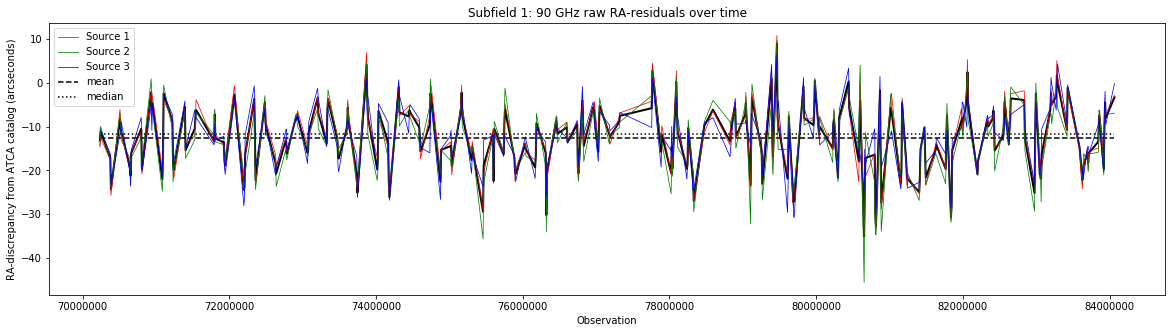

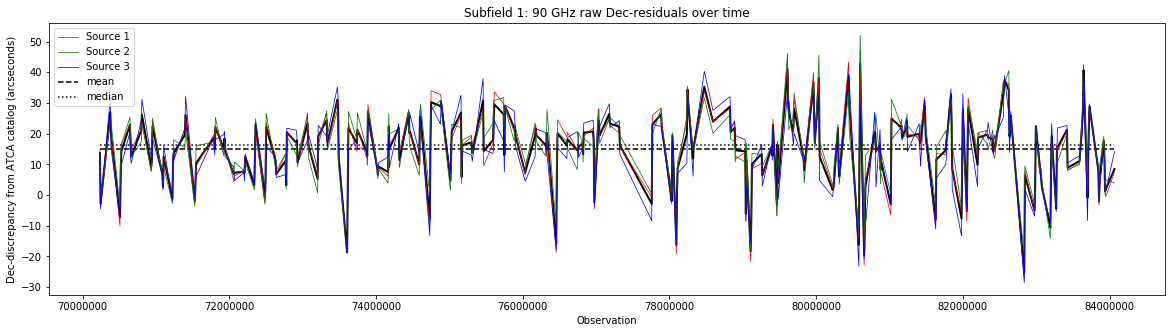

Subfield 1 appears to have a global offset from the ATCA catalog by -12.5724156771 arcseconds in RA, and 14.8466559996 arcseconds in Dec.

In Subfield 1, the RA-std is 7.44228425656 arcseconds, and the Dec-std is 11.4089523365 arcseconds.


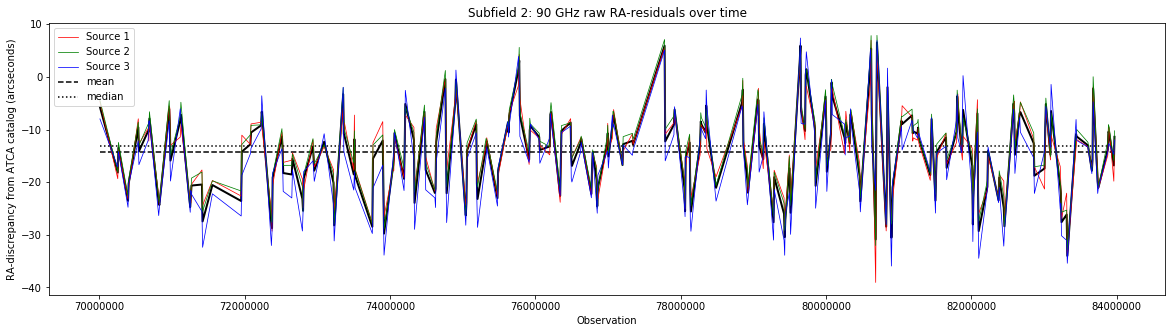

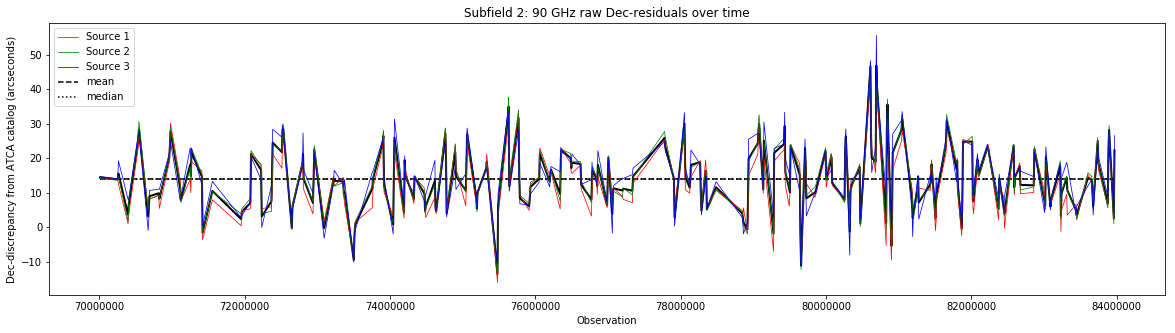

Subfield 2 appears to have a global offset from the ATCA catalog by -14.2780906784 arcseconds in RA, and 14.0414892847 arcseconds in Dec.

In Subfield 2, the RA-std is 7.8663749633 arcseconds, and the Dec-std is 9.25079251254 arcseconds.


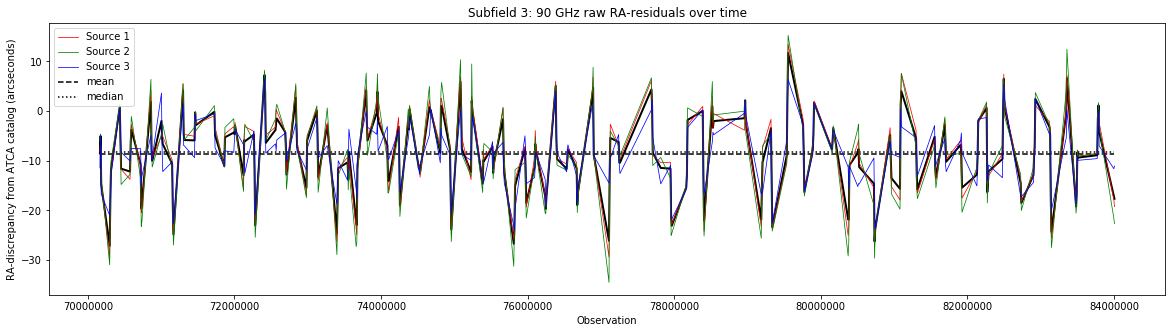

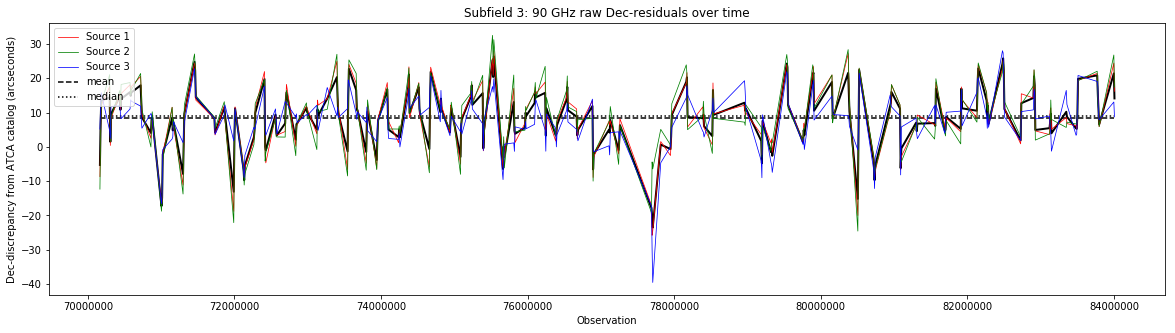

Subfield 3 appears to have a global offset from the ATCA catalog by -8.56278335339 arcseconds in RA, and 8.33639317658 arcseconds in Dec.

In Subfield 3, the RA-std is 7.74311723287 arcseconds, and the Dec-std is 8.65648669663 arcseconds.


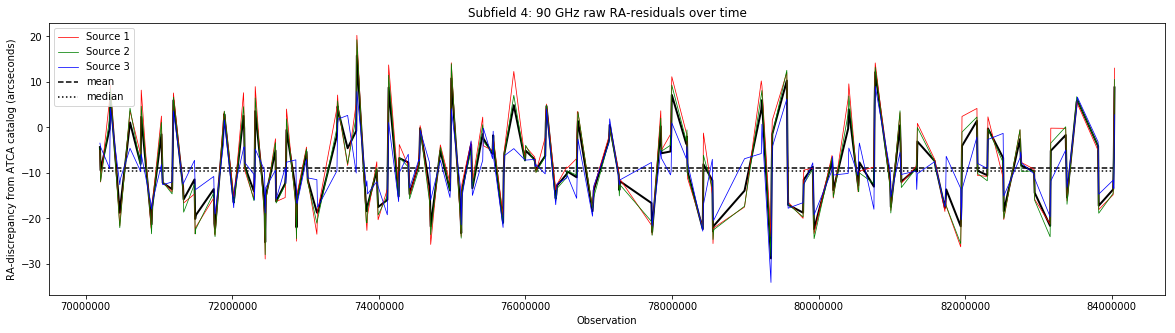

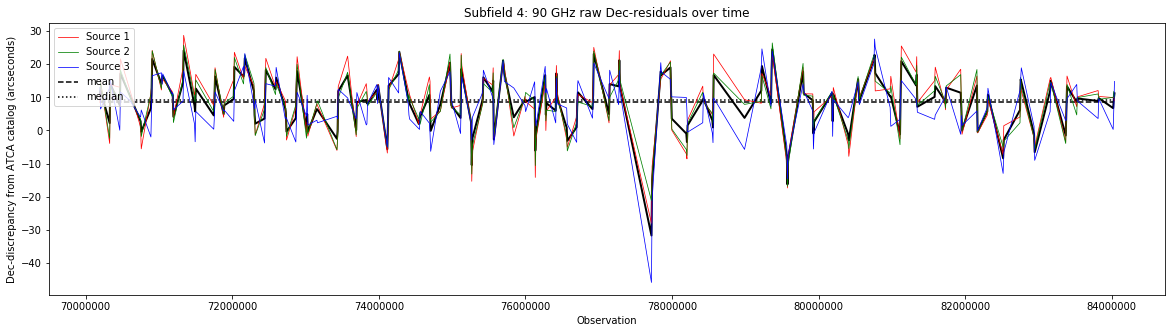

Subfield 4 appears to have a global offset from the ATCA catalog by -8.82930927887 arcseconds in RA, and 8.55222821029 arcseconds in Dec.

In Subfield 4, the RA-std is 8.43213596106 arcseconds, and the Dec-std is 8.1006053767 arcseconds.


In [16]:
plot_obs_e1 = []
plot_obs_e2 = []
plot_obs_e3 = []
plot_obs_e4 = []

plot_ra_e1_s1 = []
plot_ra_e1_s2 = []
plot_ra_e1_s3 = []
plot_ra_e1_mean = []
plot_dec_e1_s1 = []
plot_dec_e1_s2 = []
plot_dec_e1_s3 = []
plot_dec_e1_mean = []

plot_ra_e2_s1 = []
plot_ra_e2_s2 = []
plot_ra_e2_s3 = []
plot_ra_e2_mean = []
plot_dec_e2_s1 = []
plot_dec_e2_s2 = []
plot_dec_e2_s3 = []
plot_dec_e2_mean = []

plot_ra_e3_s1 = []
plot_ra_e3_s2 = []
plot_ra_e3_s3 = []
plot_ra_e3_mean = []
plot_dec_e3_s1 = []
plot_dec_e3_s2 = []
plot_dec_e3_s3 = []
plot_dec_e3_mean = []

plot_ra_e4_s1 = []
plot_ra_e4_s2 = []
plot_ra_e4_s3 = []
plot_ra_e4_mean = []
plot_dec_e4_s1 = []
plot_dec_e4_s2 = []
plot_dec_e4_s3 = []
plot_dec_e4_mean = []

for key in surviving_dict:
    if surviving_dict[key]["subfield"] == "ra0hdec-44.75":
        plot_obs_e1.append(int(key))
        plot_ra_e1_s1.append(surviving_dict[key]["RA_delta_1"])
        plot_ra_e1_s2.append(surviving_dict[key]["RA_delta_2"])
        plot_ra_e1_s3.append(surviving_dict[key]["RA_delta_3"])
        plot_ra_e1_mean.append(np.mean([surviving_dict[key]["RA_delta_1"], surviving_dict[key]["RA_delta_2"], surviving_dict[key]["RA_delta_3"]]))
        plot_dec_e1_s1.append(surviving_dict[key]["dec_delta_1"])
        plot_dec_e1_s2.append(surviving_dict[key]["dec_delta_2"])
        plot_dec_e1_s3.append(surviving_dict[key]["dec_delta_3"])
        plot_dec_e1_mean.append(np.mean([surviving_dict[key]["dec_delta_1"], surviving_dict[key]["dec_delta_2"], surviving_dict[key]["dec_delta_3"]]))
    elif surviving_dict[key]["subfield"] == "ra0hdec-52.25":
        plot_obs_e2.append(int(key))
        plot_ra_e2_s1.append(surviving_dict[key]["RA_delta_1"])
        plot_ra_e2_s2.append(surviving_dict[key]["RA_delta_2"])
        plot_ra_e2_s3.append(surviving_dict[key]["RA_delta_3"])
        plot_ra_e2_mean.append(np.mean([surviving_dict[key]["RA_delta_1"], surviving_dict[key]["RA_delta_2"], surviving_dict[key]["RA_delta_3"]]))
        plot_dec_e2_s1.append(surviving_dict[key]["dec_delta_1"])
        plot_dec_e2_s2.append(surviving_dict[key]["dec_delta_2"])
        plot_dec_e2_s3.append(surviving_dict[key]["dec_delta_3"])
        plot_dec_e2_mean.append(np.mean([surviving_dict[key]["dec_delta_1"], surviving_dict[key]["dec_delta_2"], surviving_dict[key]["dec_delta_3"]]))
    elif surviving_dict[key]["subfield"] == "ra0hdec-59.75":
        plot_obs_e3.append(int(key))
        plot_ra_e3_s1.append(surviving_dict[key]["RA_delta_1"])
        plot_ra_e3_s2.append(surviving_dict[key]["RA_delta_2"])
        plot_ra_e3_s3.append(surviving_dict[key]["RA_delta_3"])
        plot_ra_e3_mean.append(np.mean([surviving_dict[key]["RA_delta_1"], surviving_dict[key]["RA_delta_2"], surviving_dict[key]["RA_delta_3"]]))
        plot_dec_e3_s1.append(surviving_dict[key]["dec_delta_1"])
        plot_dec_e3_s2.append(surviving_dict[key]["dec_delta_2"])
        plot_dec_e3_s3.append(surviving_dict[key]["dec_delta_3"])
        plot_dec_e3_mean.append(np.mean([surviving_dict[key]["dec_delta_1"], surviving_dict[key]["dec_delta_2"], surviving_dict[key]["dec_delta_3"]]))
    elif surviving_dict[key]["subfield"] == "ra0hdec-67.25":
        plot_obs_e4.append(int(key))
        plot_ra_e4_s1.append(surviving_dict[key]["RA_delta_1"])
        plot_ra_e4_s2.append(surviving_dict[key]["RA_delta_2"])
        plot_ra_e4_s3.append(surviving_dict[key]["RA_delta_3"])
        plot_ra_e4_mean.append(np.mean([surviving_dict[key]["RA_delta_1"], surviving_dict[key]["RA_delta_2"], surviving_dict[key]["RA_delta_3"]]))
        plot_dec_e4_s1.append(surviving_dict[key]["dec_delta_1"])
        plot_dec_e4_s2.append(surviving_dict[key]["dec_delta_2"])
        plot_dec_e4_s3.append(surviving_dict[key]["dec_delta_3"])
        plot_dec_e4_mean.append(np.mean([surviving_dict[key]["dec_delta_1"], surviving_dict[key]["dec_delta_2"], surviving_dict[key]["dec_delta_3"]]))
    else:
        print("Something weird happened")

# Need to get observations in order
bundle_1 = zip(plot_obs_e1, plot_ra_e1_s1, plot_ra_e1_s2, plot_ra_e1_s3, plot_ra_e1_mean, plot_dec_e1_s1, plot_dec_e1_s2, plot_dec_e1_s3, plot_dec_e1_mean)
bundle_2 = zip(plot_obs_e2, plot_ra_e2_s1, plot_ra_e2_s2, plot_ra_e2_s3, plot_ra_e2_mean, plot_dec_e2_s1, plot_dec_e2_s2, plot_dec_e2_s3, plot_dec_e2_mean)
bundle_3 = zip(plot_obs_e3, plot_ra_e3_s1, plot_ra_e3_s2, plot_ra_e3_s3, plot_ra_e3_mean, plot_dec_e3_s1, plot_dec_e3_s2, plot_dec_e3_s3, plot_dec_e3_mean)
bundle_4 = zip(plot_obs_e4, plot_ra_e4_s1, plot_ra_e4_s2, plot_ra_e4_s3, plot_ra_e4_mean, plot_dec_e4_s1, plot_dec_e4_s2, plot_dec_e4_s3, plot_dec_e4_mean)
bundle_1 = sorted(bundle_1, key=lambda tup: tup[0])
bundle_2 = sorted(bundle_2, key=lambda tup: tup[0])
bundle_3 = sorted(bundle_3, key=lambda tup: tup[0])
bundle_4 = sorted(bundle_4, key=lambda tup: tup[0])
plot_obs_e1, plot_ra_e1_s1, plot_ra_e1_s2, plot_ra_e1_s3, plot_ra_e1_mean, plot_dec_e1_s1, plot_dec_e1_s2, plot_dec_e1_s3, plot_dec_e1_mean = zip(*bundle_1)
plot_obs_e2, plot_ra_e2_s1, plot_ra_e2_s2, plot_ra_e2_s3, plot_ra_e2_mean, plot_dec_e2_s1, plot_dec_e2_s2, plot_dec_e2_s3, plot_dec_e2_mean = zip(*bundle_2)
plot_obs_e3, plot_ra_e3_s1, plot_ra_e3_s2, plot_ra_e3_s3, plot_ra_e3_mean, plot_dec_e3_s1, plot_dec_e3_s2, plot_dec_e3_s3, plot_dec_e3_mean = zip(*bundle_3)
plot_obs_e4, plot_ra_e4_s1, plot_ra_e4_s2, plot_ra_e4_s3, plot_ra_e4_mean, plot_dec_e4_s1, plot_dec_e4_s2, plot_dec_e4_s3, plot_dec_e4_mean = zip(*bundle_4)

# Make the plots

#Subfield 1
e1_ra_offset = np.mean(plot_ra_e1_mean)
e1_ra_median = np.median(plot_ra_e1_mean)
e1_ra_jitter = np.std(plot_ra_e1_mean)

plt.figure(figsize=(20,5))
plt.plot(plot_obs_e1, plot_ra_e1_mean, color="k", lw=2)
plt.hlines(e1_ra_offset, xmin=min(plot_obs_e1), xmax=max(plot_obs_e1), colors="k", linestyles="dashed", label="mean")
plt.hlines(e1_ra_median, xmin=min(plot_obs_e1), xmax=max(plot_obs_e1), colors="k", linestyles="dotted", label="median")
plt.plot(plot_obs_e1, plot_ra_e1_s1, color="r", lw=0.75, alpha=1, label="Source 1")
plt.plot(plot_obs_e1, plot_ra_e1_s2, color="g", lw=0.75, alpha=1, label="Source 2")
plt.plot(plot_obs_e1, plot_ra_e1_s3, color="b", lw=0.75, alpha=1, label="Source 3")
plt.title("Subfield 1: 90 GHz raw RA-residuals over time")
plt.xlabel("Observation")
plt.ylabel("RA-discrepancy from ATCA catalog (arcseconds)")
plt.ticklabel_format(style="plain")
plt.legend(loc="upper left")
plt.show()

e1_dec_offset = np.mean(plot_dec_e1_mean)
e1_dec_median = np.median(plot_dec_e1_mean)
e1_dec_jitter = np.std(plot_dec_e1_mean)

plt.figure(figsize=(20,5))
plt.plot(plot_obs_e1, plot_dec_e1_mean, color="k", lw=2)
plt.hlines(e1_dec_offset, xmin=min(plot_obs_e1), xmax=max(plot_obs_e1), colors="k", linestyles="dashed", label="mean")
plt.hlines(e1_dec_median, xmin=min(plot_obs_e1), xmax=max(plot_obs_e1), colors="k", linestyles="dotted", label="median")
plt.plot(plot_obs_e1, plot_dec_e1_s1, color="r", lw=0.75, alpha=1, label="Source 1")
plt.plot(plot_obs_e1, plot_dec_e1_s2, color="g", lw=0.75, alpha=1, label="Source 2")
plt.plot(plot_obs_e1, plot_dec_e1_s3, color="b", lw=0.75, alpha=1, label="Source 3")
plt.title("Subfield 1: 90 GHz raw Dec-residuals over time")
plt.xlabel("Observation")
plt.ylabel("Dec-discrepancy from ATCA catalog (arcseconds)")
plt.ticklabel_format(style="plain")
plt.legend(loc="upper left")
plt.show()

print("Subfield 1 appears to have a global offset from the ATCA catalog by", e1_ra_offset, "arcseconds in RA, and", e1_dec_offset, "arcseconds in Dec.")
print("")
print("In Subfield 1, the RA-std is", e1_ra_jitter, "arcseconds, and the Dec-std is", e1_dec_jitter, "arcseconds.")

#Subfield 2
e2_ra_offset = np.mean(plot_ra_e2_mean)
e2_ra_median = np.median(plot_ra_e2_mean)
e2_ra_jitter = np.std(plot_ra_e2_mean)

plt.figure(figsize=(20,5))
plt.plot(plot_obs_e2, plot_ra_e2_mean, color="k", lw=2)
plt.hlines(e2_ra_offset, xmin=min(plot_obs_e2), xmax=max(plot_obs_e2), colors="k", linestyles="dashed", label="mean")
plt.hlines(e2_ra_median, xmin=min(plot_obs_e2), xmax=max(plot_obs_e2), colors="k", linestyles="dotted", label="median")
plt.plot(plot_obs_e2, plot_ra_e2_s1, color="r", lw=0.75, alpha=1, label="Source 1")
plt.plot(plot_obs_e2, plot_ra_e2_s2, color="g", lw=0.75, alpha=1, label="Source 2")
plt.plot(plot_obs_e2, plot_ra_e2_s3, color="b", lw=0.75, alpha=1, label="Source 3")
plt.title("Subfield 2: 90 GHz raw RA-residuals over time")
plt.xlabel("Observation")
plt.ylabel("RA-discrepancy from ATCA catalog (arcseconds)")
plt.ticklabel_format(style="plain")
plt.legend(loc="upper left")
plt.show()

e2_dec_offset = np.mean(plot_dec_e2_mean)
e2_dec_median = np.median(plot_dec_e2_mean)
e2_dec_jitter = np.std(plot_dec_e2_mean)

plt.figure(figsize=(20,5))
plt.plot(plot_obs_e2, plot_dec_e2_mean, color="k", lw=2)
plt.hlines(e2_dec_offset, xmin=min(plot_obs_e2), xmax=max(plot_obs_e2), colors="k", linestyles="dashed", label="mean")
plt.hlines(e2_dec_median, xmin=min(plot_obs_e2), xmax=max(plot_obs_e2), colors="k", linestyles="dotted", label="median")
plt.plot(plot_obs_e2, plot_dec_e2_s1, color="r", lw=0.75, alpha=1, label="Source 1")
plt.plot(plot_obs_e2, plot_dec_e2_s2, color="g", lw=0.75, alpha=1, label="Source 2")
plt.plot(plot_obs_e2, plot_dec_e2_s3, color="b", lw=0.75, alpha=1, label="Source 3")
plt.title("Subfield 2: 90 GHz raw Dec-residuals over time")
plt.xlabel("Observation")
plt.ylabel("Dec-discrepancy from ATCA catalog (arcseconds)")
plt.ticklabel_format(style="plain")
plt.legend(loc="upper left")
plt.show()

print("Subfield 2 appears to have a global offset from the ATCA catalog by", e2_ra_offset, "arcseconds in RA, and", e2_dec_offset, "arcseconds in Dec.")
print("")
print("In Subfield 2, the RA-std is", e2_ra_jitter, "arcseconds, and the Dec-std is", e2_dec_jitter, "arcseconds.")

#Subfield 3
e3_ra_offset = np.mean(plot_ra_e3_mean)
e3_ra_median = np.median(plot_ra_e3_mean)
e3_ra_jitter = np.std(plot_ra_e3_mean)

plt.figure(figsize=(20,5))
plt.plot(plot_obs_e3, plot_ra_e3_mean, color="k", lw=2)
plt.hlines(e3_ra_offset, xmin=min(plot_obs_e3), xmax=max(plot_obs_e3), colors="k", linestyles="dashed", label="mean")
plt.hlines(e3_ra_median, xmin=min(plot_obs_e3), xmax=max(plot_obs_e3), colors="k", linestyles="dotted", label="median")
plt.plot(plot_obs_e3, plot_ra_e3_s1, color="r", lw=0.75, alpha=1, label="Source 1")
plt.plot(plot_obs_e3, plot_ra_e3_s2, color="g", lw=0.75, alpha=1, label="Source 2")
plt.plot(plot_obs_e3, plot_ra_e3_s3, color="b", lw=0.75, alpha=1, label="Source 3")
plt.title("Subfield 3: 90 GHz raw RA-residuals over time")
plt.xlabel("Observation")
plt.ylabel("RA-discrepancy from ATCA catalog (arcseconds)")
plt.ticklabel_format(style="plain")
plt.legend(loc="upper left")
plt.show()

e3_dec_offset = np.mean(plot_dec_e3_mean)
e3_dec_median = np.median(plot_dec_e3_mean)
e3_dec_jitter = np.std(plot_dec_e3_mean)

plt.figure(figsize=(20,5))
plt.plot(plot_obs_e3, plot_dec_e3_mean, color="k", lw=2)
plt.hlines(e3_dec_offset, xmin=min(plot_obs_e3), xmax=max(plot_obs_e3), colors="k", linestyles="dashed", label="mean")
plt.hlines(e3_dec_median, xmin=min(plot_obs_e3), xmax=max(plot_obs_e3), colors="k", linestyles="dotted", label="median")
plt.plot(plot_obs_e3, plot_dec_e3_s1, color="r", lw=0.75, alpha=1, label="Source 1")
plt.plot(plot_obs_e3, plot_dec_e3_s2, color="g", lw=0.75, alpha=1, label="Source 2")
plt.plot(plot_obs_e3, plot_dec_e3_s3, color="b", lw=0.75, alpha=1, label="Source 3")
plt.title("Subfield 3: 90 GHz raw Dec-residuals over time")
plt.xlabel("Observation")
plt.ylabel("Dec-discrepancy from ATCA catalog (arcseconds)")
plt.ticklabel_format(style="plain")
plt.legend(loc="upper left")
plt.show()

print("Subfield 3 appears to have a global offset from the ATCA catalog by", e3_ra_offset, "arcseconds in RA, and", e3_dec_offset, "arcseconds in Dec.")
print("")
print("In Subfield 3, the RA-std is", e3_ra_jitter, "arcseconds, and the Dec-std is", e3_dec_jitter, "arcseconds.")

#Subfield 4
e4_ra_offset = np.mean(plot_ra_e4_mean)
e4_ra_median = np.median(plot_ra_e4_mean)
e4_ra_jitter = np.std(plot_ra_e4_mean)

plt.figure(figsize=(20,5))
plt.plot(plot_obs_e4, plot_ra_e4_mean, color="k", lw=2)
plt.hlines(e4_ra_offset, xmin=min(plot_obs_e4), xmax=max(plot_obs_e4), colors="k", linestyles="dashed", label="mean")
plt.hlines(e4_ra_median, xmin=min(plot_obs_e4), xmax=max(plot_obs_e4), colors="k", linestyles="dotted", label="median")
plt.plot(plot_obs_e4, plot_ra_e4_s1, color="r", lw=0.75, alpha=1, label="Source 1")
plt.plot(plot_obs_e4, plot_ra_e4_s2, color="g", lw=0.75, alpha=1, label="Source 2")
plt.plot(plot_obs_e4, plot_ra_e4_s3, color="b", lw=0.75, alpha=1, label="Source 3")
plt.title("Subfield 4: 90 GHz raw RA-residuals over time")
plt.xlabel("Observation")
plt.ylabel("RA-discrepancy from ATCA catalog (arcseconds)")
plt.ticklabel_format(style="plain")
plt.legend(loc="upper left")
plt.show()

e4_dec_offset = np.mean(plot_dec_e4_mean)
e4_dec_median = np.median(plot_dec_e4_mean)
e4_dec_jitter = np.std(plot_dec_e4_mean)

plt.figure(figsize=(20,5))
plt.plot(plot_obs_e4, plot_dec_e4_mean, color="k", lw=2)
plt.hlines(e4_dec_offset, xmin=min(plot_obs_e4), xmax=max(plot_obs_e4), colors="k", linestyles="dashed", label="mean")
plt.hlines(e4_dec_median, xmin=min(plot_obs_e4), xmax=max(plot_obs_e4), colors="k", linestyles="dotted", label="median")
plt.plot(plot_obs_e4, plot_dec_e4_s1, color="r", lw=0.75, alpha=1, label="Source 1")
plt.plot(plot_obs_e4, plot_dec_e4_s2, color="g", lw=0.75, alpha=1, label="Source 2")
plt.plot(plot_obs_e4, plot_dec_e4_s3, color="b", lw=0.75, alpha=1, label="Source 3")
plt.title("Subfield 4: 90 GHz raw Dec-residuals over time")
plt.xlabel("Observation")
plt.ylabel("Dec-discrepancy from ATCA catalog (arcseconds)")
plt.ticklabel_format(style="plain")
plt.legend(loc="upper left")
plt.show()

print("Subfield 4 appears to have a global offset from the ATCA catalog by", e4_ra_offset, "arcseconds in RA, and", e4_dec_offset, "arcseconds in Dec.")
print("")
print("In Subfield 4, the RA-std is", e4_ra_jitter, "arcseconds, and the Dec-std is", e4_dec_jitter, "arcseconds.")

We now plot the distribution of measured pointing-residuals from the ATCA catalog, having corrected for the global offset in each subfield.  Before plotting the master-dictionary, we filter any observations which are missing pointing-measurements for any of the 3 sources.

10 observations are missing pointing information: ['70095756', '70344984', '70482836', '70553740', '71131345', '73102483', '73582657', '75850013', '77826016', '78601914']


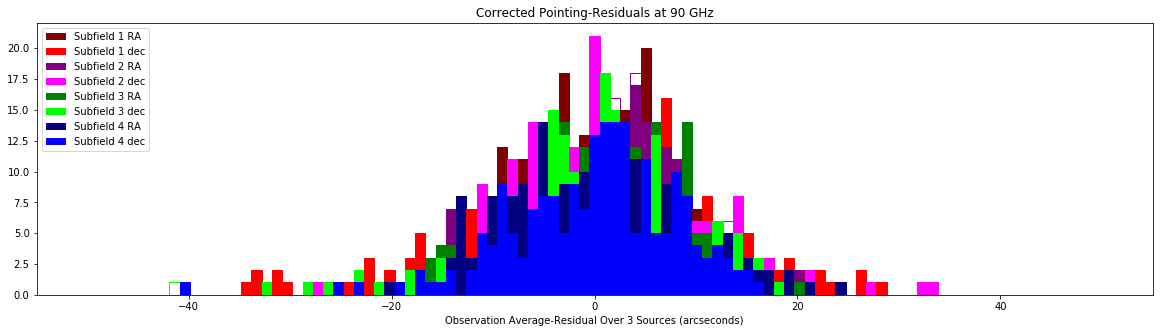

In [17]:
obs_missing_pointing = []
master_dict_pointing = master_dict.copy()

hist_pointing_1_ra_master = []
hist_pointing_1_dec_master = []
hist_pointing_2_ra_master = []
hist_pointing_2_dec_master = []
hist_pointing_3_ra_master = []
hist_pointing_3_dec_master = []
hist_pointing_4_ra_master = []
hist_pointing_4_dec_master = []

hist_pointing_1_ra_surviving = []
hist_pointing_1_dec_surviving = []
hist_pointing_2_ra_surviving = []
hist_pointing_2_dec_surviving = []
hist_pointing_3_ra_surviving = []
hist_pointing_3_dec_surviving = []
hist_pointing_4_ra_surviving = []
hist_pointing_4_dec_surviving = []

#Find observations in master_dict that are missing pointing-measurements
for key in master_dict:
    pointing_value_list = [master_dict[key]["RA_delta_1"], master_dict[key]["RA_delta_2"], master_dict[key]["RA_delta_3"],
                            master_dict[key]["dec_delta_1"], master_dict[key]["dec_delta_2"], master_dict[key]["dec_delta_3"]]
    pointing_flag_list = np.isfinite(pointing_value_list)
    if all(pointing_flag_list):
        continue
    else:
        obs_missing_pointing.append(key)
        continue

print(len(obs_missing_pointing), "observations are missing pointing information:", sorted(obs_missing_pointing))

for obs in obs_missing_pointing:
    master_dict_pointing.pop(obs)

#Populate the histogram lists
for key in master_dict_pointing:
    if master_dict[key]["subfield"] == "ra0hdec-44.75":
        hist_pointing_1_ra_master.append(np.mean([master_dict[key]["RA_delta_1"], master_dict[key]["RA_delta_2"], master_dict[key]["RA_delta_3"]])
                                          - e1_ra_offset)
        hist_pointing_1_dec_master.append(np.mean([master_dict[key]["dec_delta_1"], master_dict[key]["dec_delta_2"], master_dict[key]["dec_delta_3"]])
                                          - e1_dec_offset)
    elif master_dict[key]["subfield"] == "ra0hdec-52.25":
        hist_pointing_2_ra_master.append(np.mean([master_dict[key]["RA_delta_1"], master_dict[key]["RA_delta_2"], master_dict[key]["RA_delta_3"]])
                                          - e2_ra_offset)
        hist_pointing_2_dec_master.append(np.mean([master_dict[key]["dec_delta_1"], master_dict[key]["dec_delta_2"], master_dict[key]["dec_delta_3"]])
                                          - e2_dec_offset)
    elif master_dict[key]["subfield"] == "ra0hdec-59.75":
        hist_pointing_3_ra_master.append(np.mean([master_dict[key]["RA_delta_1"], master_dict[key]["RA_delta_2"], master_dict[key]["RA_delta_3"]])
                                          - e3_ra_offset)
        hist_pointing_3_dec_master.append(np.mean([master_dict[key]["dec_delta_1"], master_dict[key]["dec_delta_2"], master_dict[key]["dec_delta_3"]])
                                          - e3_dec_offset)
    elif master_dict[key]["subfield"] == "ra0hdec-67.25":
        hist_pointing_4_ra_master.append(np.mean([master_dict[key]["RA_delta_1"], master_dict[key]["RA_delta_2"], master_dict[key]["RA_delta_3"]])
                                          - e4_ra_offset)
        hist_pointing_4_dec_master.append(np.mean([master_dict[key]["dec_delta_1"], master_dict[key]["dec_delta_2"], master_dict[key]["dec_delta_3"]])
                                          - e4_dec_offset)
    else:
        print("Something weird happened")

for key in surviving_dict:
    if master_dict[key]["subfield"] == "ra0hdec-44.75":
        hist_pointing_1_ra_surviving.append(np.mean([master_dict[key]["RA_delta_1"], master_dict[key]["RA_delta_2"], master_dict[key]["RA_delta_3"]])
                                          - e1_ra_offset)
        hist_pointing_1_dec_surviving.append(np.mean([master_dict[key]["dec_delta_1"], master_dict[key]["dec_delta_2"], master_dict[key]["dec_delta_3"]])
                                          - e1_dec_offset)
    elif master_dict[key]["subfield"] == "ra0hdec-52.25":
        hist_pointing_2_ra_surviving.append(np.mean([master_dict[key]["RA_delta_1"], master_dict[key]["RA_delta_2"], master_dict[key]["RA_delta_3"]])
                                          - e2_ra_offset)
        hist_pointing_2_dec_surviving.append(np.mean([master_dict[key]["dec_delta_1"], master_dict[key]["dec_delta_2"], master_dict[key]["dec_delta_3"]])
                                          - e2_dec_offset)
    elif master_dict[key]["subfield"] == "ra0hdec-59.75":
        hist_pointing_3_ra_surviving.append(np.mean([master_dict[key]["RA_delta_1"], master_dict[key]["RA_delta_2"], master_dict[key]["RA_delta_3"]])
                                          - e3_ra_offset)
        hist_pointing_3_dec_surviving.append(np.mean([master_dict[key]["dec_delta_1"], master_dict[key]["dec_delta_2"], master_dict[key]["dec_delta_3"]])
                                          - e3_dec_offset)
    elif master_dict[key]["subfield"] == "ra0hdec-67.25":
        hist_pointing_4_ra_surviving.append(np.mean([master_dict[key]["RA_delta_1"], master_dict[key]["RA_delta_2"], master_dict[key]["RA_delta_3"]])
                                          - e4_ra_offset)
        hist_pointing_4_dec_surviving.append(np.mean([master_dict[key]["dec_delta_1"], master_dict[key]["dec_delta_2"], master_dict[key]["dec_delta_3"]])
                                          - e4_dec_offset)
    else:
        print("Something weird happened")

hist_pointing_bin_edges = np.linspace(-50, 50, 100)

plt.figure(figsize=(20,5))
plt.hist(hist_pointing_1_ra_master, bins=hist_pointing_bin_edges, histtype="step", color="maroon")
plt.hist(hist_pointing_1_dec_master, bins=hist_pointing_bin_edges, histtype="step", color="red")
plt.hist(hist_pointing_2_ra_master, bins=hist_pointing_bin_edges, histtype="step", color="purple")
plt.hist(hist_pointing_2_dec_master, bins=hist_pointing_bin_edges, histtype="step", color="fuchsia")
plt.hist(hist_pointing_3_ra_master, bins=hist_pointing_bin_edges, histtype="step", color="green")
plt.hist(hist_pointing_3_dec_master, bins=hist_pointing_bin_edges, histtype="step", color="lime")
plt.hist(hist_pointing_4_ra_master, bins=hist_pointing_bin_edges, histtype="step", color="navy")
plt.hist(hist_pointing_4_dec_master, bins=hist_pointing_bin_edges, histtype="step", color="blue")
plt.hist(hist_pointing_1_ra_surviving, bins=hist_pointing_bin_edges, color="maroon", label="Subfield 1 RA")
plt.hist(hist_pointing_1_dec_surviving, bins=hist_pointing_bin_edges, color="red", label="Subfield 1 dec")
plt.hist(hist_pointing_2_ra_surviving, bins=hist_pointing_bin_edges, color="purple", label="Subfield 2 RA")
plt.hist(hist_pointing_2_dec_surviving, bins=hist_pointing_bin_edges, color="fuchsia", label="Subfield 2 dec")
plt.hist(hist_pointing_3_ra_surviving, bins=hist_pointing_bin_edges, color="green", label="Subfield 3 RA")
plt.hist(hist_pointing_3_dec_surviving, bins=hist_pointing_bin_edges, color="lime", label="Subfield 3 dec")
plt.hist(hist_pointing_4_ra_surviving, bins=hist_pointing_bin_edges, color="navy", label="Subfield 4 RA")
plt.hist(hist_pointing_4_dec_surviving, bins=hist_pointing_bin_edges, color="blue", label="Subfield 4 dec")
plt.title("Corrected Pointing-Residuals at 90 GHz")
plt.xlabel("Observation Average-Residual Over 3 Sources (arcseconds)")
plt.legend(loc="upper left")
plt.show()

In [18]:
obs_bad_pointing_master = []
obs_bad_pointing_surviving = []

def determine_offsets(key):
    if master_dict[key]["subfield"] == "ra0hdec-44.75":
        return e1_ra_offset, e1_dec_offset
    elif master_dict[key]["subfield"] == "ra0hdec-52.25":
        return e2_ra_offset, e2_dec_offset
    elif master_dict[key]["subfield"] == "ra0hdec-59.75":
        return e3_ra_offset, e3_dec_offset
    elif master_dict[key]["subfield"] == "ra0hdec-67.25":
        return e4_ra_offset, e4_dec_offset
    else:
        print("Something weird happened")
    
for key in master_dict_pointing:
    ra_offset, dec_offset = determine_offsets(key)
    if not -50 < (np.mean([master_dict[key]["RA_delta_1"], master_dict[key]["RA_delta_2"], master_dict[key]["RA_delta_3"]])-ra_offset) < 50:
        obs_bad_pointing_master.append(key)
    elif not -50 < (np.mean([master_dict[key]["dec_delta_1"], master_dict[key]["dec_delta_2"], master_dict[key]["dec_delta_3"]])-dec_offset) < 50:
        obs_bad_pointing_master.append(key)
    else:
        continue

for key in surviving_dict:
    ra_offset, dec_offset = determine_offsets(key)
    if not -50 < (np.mean([master_dict[key]["RA_delta_1"], master_dict[key]["RA_delta_2"], master_dict[key]["RA_delta_3"]])-ra_offset) < 50:
        obs_bad_pointing_surviving.append(key)
    elif not -50 < (np.mean([master_dict[key]["dec_delta_1"], master_dict[key]["dec_delta_2"], master_dict[key]["dec_delta_3"]])-dec_offset) < 50:
        obs_bad_pointing_surviving.append(key)
    else:
        continue

print(len(obs_bad_pointing_master), "observations have a large pointing error:", sorted(obs_bad_pointing_master))
print("")
print(len(obs_bad_pointing_surviving), "new observations have a large pointing error:", sorted(obs_bad_pointing_surviving))

for obs in obs_bad_pointing_surviving:
    surviving_dict.pop(obs)

print("")
print(len(surviving_dict.keys()), "observations remain.")

0 observations have a large pointing error: []

0 new observations have a large pointing error: []

979 observations remain.


# Investigate Linearity (Calibration v. Elevation) #

We track the percent-change of the median calibrator-response across all bolometers, at the bottom and top of the subfield.  When considering observations in the master-dictionary, we again filter out any observations which are missing calibrator data.

39 observations are missing calibrator information at the top/bottom of the field: ['70008378', '70019142', '70095756', '70344984', '70412736', '70482836', '70553740', '70613613', '71131345', '71825113', '71899844', '72243773', '73102483', '73275784', '73582657', '75850013', '78601914', '82301200', '82310114', '82335631', '82344369', '82795786', '82837159', '82948115', '82977151', '82985889', '82994788', '83006197', '83015021', '83023892', '83120993', '83129776', '83138559', '83147367', '83158827', '83167741', '83193111', '83201849', '83864978']
22 new observations are missing calibrator information ['70008378', '82301200', '82310114', '82335631', '82344369', '82837159', '82948115', '82977151', '82985889', '82994788', '83006197', '83015021', '83023892', '83120993', '83129776', '83138559', '83147367', '83158827', '83167741', '83193111', '83201849', '83864978']


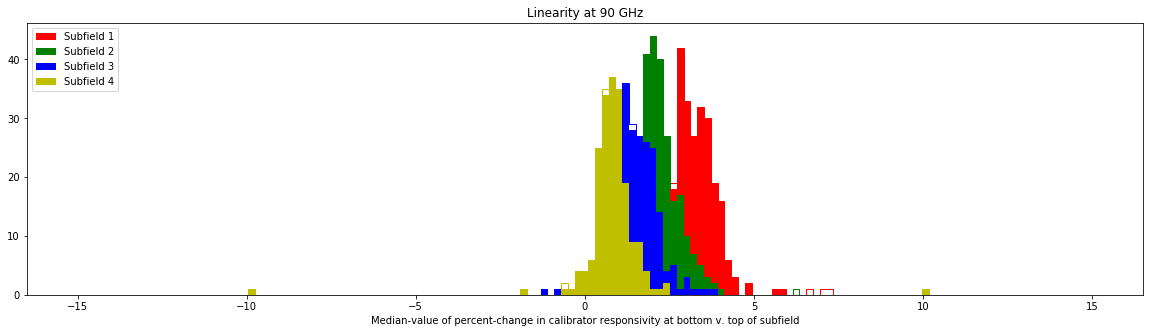

In [19]:
obs_missing_linearity = []
obs_missing_linearity_surviving = []
master_dict_linearity = master_dict.copy()

hist_linearity_1_master = []
hist_linearity_2_master = []
hist_linearity_3_master = []
hist_linearity_4_master = []

hist_linearity_1_surviving = []
hist_linearity_2_surviving = []
hist_linearity_3_surviving = []
hist_linearity_4_surviving = []

#Find observations in master_dict that are missing linearity-measurements
for key in master_dict:
    if np.isfinite(master_dict[key]["linearity"]):
        continue
    else:
        obs_missing_linearity.append(key)
        continue

print(len(obs_missing_linearity), "observations are missing calibrator information at the top/bottom of the field:", sorted(obs_missing_linearity))

for obs in obs_missing_linearity:
    master_dict_linearity.pop(obs)
    if obs in surviving_dict.keys():
        surviving_dict.pop(obs)
        obs_missing_linearity_surviving.append(obs)
    else:
        continue

print(len(obs_missing_linearity_surviving), "new observations are missing calibrator information", sorted(obs_missing_linearity_surviving))

#Populate the histogram lists

for key in master_dict_linearity:
    if master_dict[key]["subfield"] == "ra0hdec-44.75":
        hist_linearity_1_master.append(master_dict[key]["linearity"])
    elif master_dict[key]["subfield"] == "ra0hdec-52.25":
        hist_linearity_2_master.append(master_dict[key]["linearity"])
    elif master_dict[key]["subfield"] == "ra0hdec-59.75":
        hist_linearity_3_master.append(master_dict[key]["linearity"])
    elif master_dict[key]["subfield"] == "ra0hdec-67.25":
        hist_linearity_4_master.append(master_dict[key]["linearity"])
    else:
        print("Something weird happened")

for key in surviving_dict:
    if master_dict[key]["subfield"] == "ra0hdec-44.75":
        hist_linearity_1_surviving.append(master_dict[key]["linearity"])
    elif master_dict[key]["subfield"] == "ra0hdec-52.25":
        hist_linearity_2_surviving.append(master_dict[key]["linearity"])
    elif master_dict[key]["subfield"] == "ra0hdec-59.75":
        hist_linearity_3_surviving.append(master_dict[key]["linearity"])
    elif master_dict[key]["subfield"] == "ra0hdec-67.25":
        hist_linearity_4_surviving.append(master_dict[key]["linearity"])
    else:
        print("Something weird happened")

hist_linearity_bin_edges = np.linspace(-15, 15, 150)

plt.figure(figsize=(20,5))
plt.hist(hist_linearity_1_master, bins=hist_linearity_bin_edges, histtype="step", color="r")
plt.hist(hist_linearity_2_master, bins=hist_linearity_bin_edges, histtype="step", color="g")
plt.hist(hist_linearity_3_master, bins=hist_linearity_bin_edges, histtype="step", color="b")
plt.hist(hist_linearity_4_master, bins=hist_linearity_bin_edges, histtype="step", color="y")
plt.hist(hist_linearity_1_surviving, bins=hist_linearity_bin_edges, color="r", label="Subfield 1")
plt.hist(hist_linearity_2_surviving, bins=hist_linearity_bin_edges, color="g", label="Subfield 2")
plt.hist(hist_linearity_3_surviving, bins=hist_linearity_bin_edges, color="b", label="Subfield 3")
plt.hist(hist_linearity_4_surviving, bins=hist_linearity_bin_edges, color="y", label="Subfield 4")
plt.title("Linearity at 90 GHz")
plt.xlabel("Median-value of percent-change in calibrator responsivity at bottom v. top of subfield")
plt.legend(loc="upper left")
plt.show()

In [20]:
obs_bad_linearity_master = []
obs_bad_linearity_surviving = []

for key in master_dict_linearity:
    if not -1 < master_dict[key]["linearity"] < 5:
        obs_bad_linearity_master.append(key)
    else:
        continue
for key in surviving_dict:
    if not -1 < master_dict[key]["linearity"] < 5:
        obs_bad_linearity_surviving.append(key)
    else:
        continue

print(len(obs_bad_linearity_master), "observations have a significant change in calibrator-responsivity:", sorted(obs_bad_linearity_master))
print("")
print(len(obs_bad_linearity_surviving), "new observations have a significant change in calibrator-responsivity:", sorted(obs_bad_linearity_surviving))

for obs in obs_bad_linearity_surviving:
    surviving_dict.pop(obs)

print("")
print(len(surviving_dict.keys()), "observations remain.")

10 observations have a significant change in calibrator-responsivity: ['70366963', '70748993', '71764820', '74677973', '78237672', '78312893', '78816157', '78989126', '80442203', '82364506']

6 new observations have a significant change in calibrator-responsivity: ['70748993', '71764820', '74677973', '78237672', '78989126', '80442203']

951 observations remain.


# Investigate Calibration #

We calculate the cross-spectrum of an observation and Planck-map (in the same field), and divide by the auto-spectrum of the Plank-map.  We then take the average of this ratio between 750 < $\ell < 1250.  This cross-spectrum compares a 5 x 5 deg patch in the center of each sub-field.

So if SPT's calibration is perfect compared to Planck, we expect this ratio of (SPT x Planck)/(Planck x Planck) to equal 1, here.

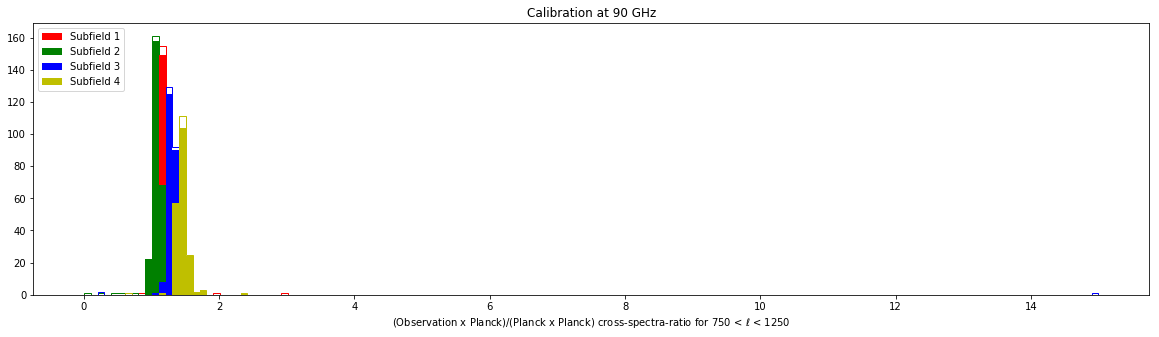

In [21]:
hist_calibration_1_master = []
hist_calibration_2_master = []
hist_calibration_3_master = []
hist_calibration_4_master = []

hist_calibration_1_surviving = []
hist_calibration_2_surviving = []
hist_calibration_3_surviving = []
hist_calibration_4_surviving = []

for key in master_dict:
    if master_dict[key]["subfield"] == "ra0hdec-44.75":
        hist_calibration_1_master.append(master_dict[key]["cross_spectrum"])
    elif master_dict[key]["subfield"] == "ra0hdec-52.25":
        hist_calibration_2_master.append(master_dict[key]["cross_spectrum"])
    elif master_dict[key]["subfield"] == "ra0hdec-59.75":
        hist_calibration_3_master.append(master_dict[key]["cross_spectrum"])
    elif master_dict[key]["subfield"] == "ra0hdec-67.25":
        hist_calibration_4_master.append(master_dict[key]["cross_spectrum"])
    else:
        print("Something weird happened")

for key in surviving_dict:
    if master_dict[key]["subfield"] == "ra0hdec-44.75":
        hist_calibration_1_surviving.append(master_dict[key]["cross_spectrum"])
    elif master_dict[key]["subfield"] == "ra0hdec-52.25":
        hist_calibration_2_surviving.append(master_dict[key]["cross_spectrum"])
    elif master_dict[key]["subfield"] == "ra0hdec-59.75":
        hist_calibration_3_surviving.append(master_dict[key]["cross_spectrum"])
    elif master_dict[key]["subfield"] == "ra0hdec-67.25":
        hist_calibration_4_surviving.append(master_dict[key]["cross_spectrum"])
    else:
        print("Something weird happened")

hist_calibration_bin_edges = np.linspace(0, 15, 150)

plt.figure(figsize=(20,5))
plt.hist(hist_calibration_1_master, bins=hist_calibration_bin_edges, histtype="step", color="r")
plt.hist(hist_calibration_2_master, bins=hist_calibration_bin_edges, histtype="step", color="g")
plt.hist(hist_calibration_3_master, bins=hist_calibration_bin_edges, histtype="step", color="b")
plt.hist(hist_calibration_4_master, bins=hist_calibration_bin_edges, histtype="step", color="y")
plt.hist(hist_calibration_1_surviving, bins=hist_calibration_bin_edges, color="r", label="Subfield 1")
plt.hist(hist_calibration_2_surviving, bins=hist_calibration_bin_edges, color="g", label="Subfield 2")
plt.hist(hist_calibration_3_surviving, bins=hist_calibration_bin_edges, color="b", label="Subfield 3")
plt.hist(hist_calibration_4_surviving, bins=hist_calibration_bin_edges, color="y", label="Subfield 4")
plt.title("Calibration at 90 GHz")
plt.xlabel("(Observation x Planck)/(Planck x Planck) cross-spectra-ratio for 750 < $\ell$ < 1250")
plt.legend(loc="upper left")
plt.show()

In [22]:
obs_bad_calibration_master = []
obs_bad_calibration_surviving = []

for key in master_dict:
    if not 0.5 < master_dict[key]["cross_spectrum"] < 2.0:
        obs_bad_calibration_master.append(key)
    else:
        continue
for key in surviving_dict:
    if not 0.5 < master_dict[key]["cross_spectrum"] < 2.0:
        obs_bad_calibration_surviving.append(key)
    else:
        continue

print(len(obs_bad_calibration_master), "observations seem to have a calibration issue:", sorted(obs_bad_calibration_master))
print("")
print(len(obs_bad_calibration_surviving), "new observations seem to have a calibration issue:", sorted(obs_bad_calibration_surviving))

for obs in obs_bad_calibration_surviving:
    surviving_dict.pop(obs)

print("")
print(len(surviving_dict.keys()), "observations remain.")

8 observations seem to have a calibration issue: ['70553740', '71131345', '71718785', '71853745', '73102483', '74698219', '77826016', '78816157']

1 new observations seem to have a calibration issue: ['74698219']

950 observations remain.


# Assemble Final Exclusion List #

In [23]:
final_exclusion_list = []

for key in master_dict:
    if key not in surviving_dict.keys():
        final_exclusion_list.append(key)
    else:
        continue

print(len(master_dict.keys()), "potentially-usable observations in date-range.")
print("")
print(len(final_exclusion_list), "observations will be excluded.")
print("")
print("Final Exclusion List:", sorted(final_exclusion_list))

1008 potentially-usable observations in date-range.

58 observations will be excluded.

Final Exclusion List: ['70008378', '70019142', '70095756', '70344984', '70366963', '70412736', '70482836', '70553740', '70613613', '70748993', '71131345', '71718785', '71764820', '71825113', '71853745', '71899844', '72243773', '73102483', '73275784', '73582657', '74677973', '74698219', '75850013', '77826016', '77834811', '78237672', '78312893', '78601914', '78816157', '78989126', '78997909', '79006720', '80442203', '82301200', '82310114', '82335631', '82344369', '82353107', '82364506', '82795786', '82837159', '82948115', '82977151', '82985889', '82994788', '83006197', '83015021', '83023892', '83120993', '83129776', '83138559', '83147367', '83158827', '83167741', '83193111', '83201849', '83298960', '83864978']


In [24]:
obs_excluded_1 = []
obs_excluded_2 = []
obs_excluded_3 = []
obs_excluded_4 = []

for obs in final_exclusion_list:
    if master_dict[obs]["subfield"] == "ra0hdec-44.75":
        obs_excluded_1.append(obs)
    elif master_dict[obs]["subfield"] == "ra0hdec-52.25":
        obs_excluded_2.append(obs)
    elif master_dict[obs]["subfield"] == "ra0hdec-59.75":
        obs_excluded_3.append(obs)
    elif master_dict[obs]["subfield"] == "ra0hdec-67.25":
        obs_excluded_4.append(obs)
    else:
        print("Something weird happened")

print(len(obs_excluded_1), "observations in Subfield 1")
print("")
print(len(obs_excluded_2), "observations in Subfield 2")
print("")
print(len(obs_excluded_3), "observations in Subfield 3")
print("")
print(len(obs_excluded_4), "observations in Subfield 4")

18 observations in Subfield 1

12 observations in Subfield 2

11 observations in Subfield 3

17 observations in Subfield 4
